In [300]:
import numpy as np
import cv2
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skimage.morphology import skeletonize
from skimage.util import invert
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import root_mean_squared_error

In [301]:
def load_binary_image(image_path, crop_top=0, crop_bottom=0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) #image to grayscale
    image=image[crop_top:crop_bottom]
    _, binary_image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY) #grayscale to binary
    return binary_image

In [302]:
get_img = invert(load_binary_image('photo12.jpeg', 0, 150))

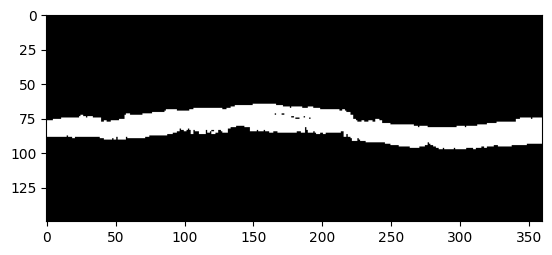

In [303]:
plt.imshow(get_img, cmap='gray')

In [304]:
blur = cv2.GaussianBlur(get_img, (5,5),0)

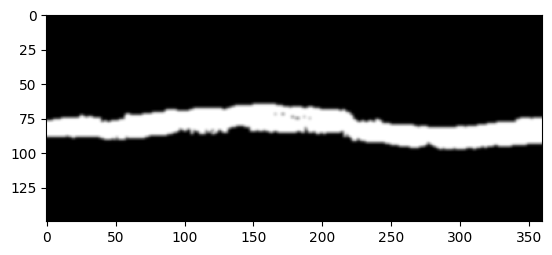

In [305]:
plt.imshow(blur, cmap='gray')

In [306]:
kernel = np.ones((1, 5), np.uint8)
closed = cv2.morphologyEx(blur, cv2.MORPH_CLOSE, kernel)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

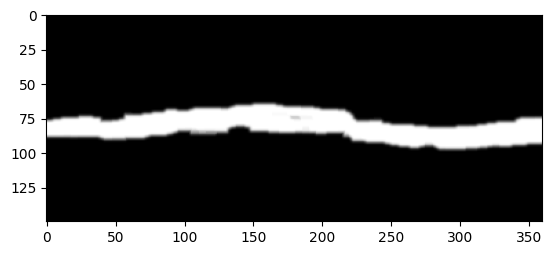

In [307]:
plt.imshow(opened, cmap='gray')

In [308]:
get_skeleton = skeletonize(opened).astype(np.uint8)

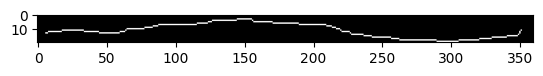

In [309]:
plt.imshow(get_skeleton[70:90, :], cmap='gray')

In [310]:
def extract_points_from_image(binary_image):

    points = np.argwhere(binary_image > 0)
 
    x = points[..., 1]
    y = points[..., 0] 
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]
    return x, y

In [311]:
x_points,y_points = extract_points_from_image(get_skeleton)

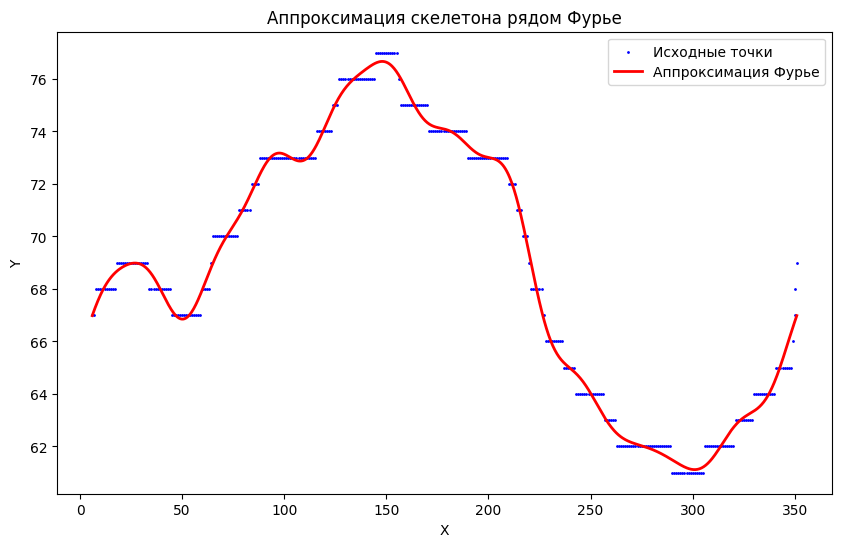

Коэффициенты ряда Фурье:
a0 = 81.23403792367078
a1 = -4.794584141409326, b1 = 4.59142387153088
a2 = 0.027877127344923584, b2 = -1.771459911856665
a3 = -0.02460355455657157, b3 = -0.5182754586174004
a4 = -0.4857661902788385, b4 = -0.275438567103274
a5 = -0.24900238070051892, b5 = -0.5964433636404041
a6 = -0.42222671640501835, b6 = 0.45338452364653536
a7 = -0.06378529017309885, b7 = 0.010097081521064203
a8 = 0.013317838830080619, b8 = 0.08892674258636679
a9 = -0.17745460973118496, b9 = 0.09836397595230896
a10 = 0.027154398841620984, b10 = -0.12819833296444846
a11 = 0.1384172668468663, b11 = -0.03223188913491325
a12 = -0.12411330943224722, b12 = -0.13907157423819644


In [312]:
#Ограниченный ряд фурье
def fourier_series(x, *params):
    y = params[0] * np.ones_like(x)
    for i in range(1, len(params)//2 + 1):
        n = i
        ai = params[2*i-1] if (2*i-1) < len(params) else 0
        bi = params[2*i] if 2*i < len(params) else 0
        y += ai * np.sin(2 * np.pi * n * x / max(x)) + bi * np.cos(2 * np.pi * n * x / max(x))
    return y

# Normalize x
scaler = MinMaxScaler()
x_norm = scaler.fit_transform(x_points.reshape(-1, 1)).flatten()


num_harmonics = 12

initial_guess = [np.mean(y_points)] + [0] * 2 * num_harmonics


popt, pcov = curve_fit(fourier_series, x_norm, y_points, p0=initial_guess, maxfev=10000)


x_smooth = np.linspace(min(x_norm), max(x_norm), 1000)
y_smooth = fourier_series(x_smooth, *popt)

# Обратное преобразование x для отображения в оригинальных координатах
x_smooth_orig = scaler.inverse_transform(x_smooth.reshape(-1, 1)).flatten()
#Переворачиваем график
height = get_img.shape[0]
# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(x_points, height - y_points, s=1, color='blue', label='Исходные точки')
plt.plot(x_smooth_orig, height - y_smooth, color='red', linewidth=2, label='Аппроксимация Фурье')

plt.legend()
plt.title('Аппроксимация скелетона рядом Фурье')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Вывод коэффициентов
print("Коэффициенты ряда Фурье:")
print(f"a0 = {popt[0]}")
for i in range(1, len(popt)//2 + 1):
    print(f"a{i} = {popt[2*i-1] if (2*i-1) < len(popt) else 0}, b{i} = {popt[2*i] if 2*i < len(popt) else 0}")


In [313]:
def adjusted_r2(y_true, y_pred, n_params):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    return 1 - ( (1 - r2) * (n - 1) ) / (n - n_params - 1 )

In [314]:
def nrmse(y_ground, y_pred):
    return 1- (root_mean_squared_error(y_ground, y_pred)/(np.max(y_ground)-np.min(y_ground)))

In [315]:
y_pred = fourier_series(x_norm, *popt)
r2 = r2_score(y_points, y_pred)
adj_r2 = adjusted_r2(y_points, y_pred, num_harmonics * 2 + 1)
cos_sim = cosine_similarity(y_points.reshape(-1,1),y_pred.reshape(-1,1))[0][0]
normmse = nrmse(y_points,y_pred)

nrmse = 1- (root_mean_squared_error(y_points, y_pred)/(np.max(y_points)-np.min(y_points)))
print(f"R2 = {r2:.4f}")
print(f"adjusted R2 = {adj_r2:.4f}") #promising
print(f"Cos simil = {cos_sim:.4f}")
print(f"NRMSE = {normmse:.4f}") #promising

R2 = 0.9939
adjusted R2 = 0.9934
Cos simil = 1.0000
NRMSE = 0.9759
